In [1]:
import sys
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
import warnings
warnings.filterwarnings('ignore')


def get_path():
    cur_path = os.getcwd()
    parent_path = os.path.dirname(cur_path)
    return cur_path, parent_path


def file_path(data_path, file):
    return os.path.abspath(os.path.join(data_path, f'{file}'))


def df_write(data_path, df, file):
    df = df.copy()
    df.to_csv(os.path.abspath(os.path.join(data_path, file)), index=False)


def split_train_test(df, configs):
    df = df.copy()
    X = df.drop(columns=configs['y_col'][0])
    y = df[configs['y_col'][0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=configs['y_col'][0])
    return X_train, X_test, y_train, y_test


def model_selection(option='logistic'):
    if option == 'LGBM':
        return lgb.LGBMClassifier(random_state=0)
    else:
        return LogisticRegression(random_state=0)


def read_data(configs):
    if configs['date_col'][0] == ' ':
        df = pd.read_csv(configs['file_name'][0])
    else:
        df = pd.read_csv(configs['file_name'][0], parse_dates=configs['date_col'])

    if configs['remove_col'][0] == ' ':
        pass
    else:
        if configs['remove_col'][0] in df.columns.to_list():
            df = df.drop(configs['remove_col'][0], axis=1)

    return df


def y_label_enc(df, configs):
    df = df.copy()
    Y_col = configs['y_col'][0]
    if df[Y_col].isnull().any():
        Y_null = True
    else:
        Y_null = False
    labeler = LabelEncoder()
    df[Y_col] = labeler.fit_transform(df[Y_col])
    return df, Y_null


def organize_data(df, configs, y_null):
    df = df.copy()
    cols = df.columns.to_list()
    null_threshhold_cols = []
    no_null_cols = []
    date_time = configs['date_col']
    Y_col = configs['y_col'][0]

    for col in cols:
        null_mean = df[col].isnull().mean()
        if null_mean >= configs['null_threshhold'][0]:
            null_threshhold_cols.append(col)
        if null_mean == 0:
            no_null_cols.append(col)

    cols_stayed = [item for item in cols if item not in null_threshhold_cols]
    data = df[cols_stayed].copy()

    # numerical: discrete vs continuous
    discrete = [var for var in cols_stayed if
                data[var].dtype != 'O' and var != Y_col and var not in date_time and data[var].nunique() < 10]
    continuous = [var for var in cols_stayed if
                  data[var].dtype != 'O' and var != Y_col and var not in date_time and var not in discrete]

    # categorical
    categorical = [var for var in cols_stayed if data[var].dtype == 'O' and var != Y_col]

    print('There are {} date_time variables'.format(len(date_time)))
    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))

    if y_null:
        data = data[data[Y_col] != data[Y_col].max()].copy()
    else:
        data = data.copy()

    return data, discrete, continuous, categorical


def split_train_test(df, configs):
    df = df.copy()
    X = df.drop(columns=configs['y_col'][0])
    y = df[configs['y_col'][0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configs['test_size'][0], random_state=0, stratify=y)
    return X_train, X_test, y_train, y_test


def make_imputer_pipe(continuous, discrete, categorical):
    numberImputer = continuous + discrete
    categoricalImputer = categorical

    if (len(numberImputer) > 0) & (len(categoricalImputer) > 0):
        pipe = Pipeline([
            ("median_imputer",
             mdi.MeanMedianImputer(
                 imputation_method="median", variables=numberImputer),),

            ('imputer_cat',
             mdi.CategoricalImputer(variables=categoricalImputer)),

            ('categorical_encoder',
             ce.OrdinalEncoder(encoding_method='ordered',
                               variables=categoricalImputer))
        ])
    else:
        if (len(numberImputer) > 0) & (len(categoricalImputer) == 0):
            pipe = Pipeline([
                ("median_imputer",
                 mdi.MeanMedianImputer(
                     imputation_method="median", variables=numberImputer),)
            ])
        else:
            if (len(numberImputer) == 0) & (len(categoricalImputer) > 0):
                pipe = Pipeline([
                    ('imputer_cat',
                     mdi.CategoricalImputer(variables=categoricalImputer)),

                    ('categorical_encoder',
                     ce.OrdinalEncoder(encoding_method='ordered',
                                       variables=categoricalImputer))
                ])
            else:
                pipe = []
    return pipe


def do_imputation(X_train, X_test, y_train, y_test, pipe):
    X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
    if pipe != []:
        pipe.fit(X_train, y_train)
        X_train = pipe.transform(X_train)
        X_test = pipe.transform(X_test)
    else:
        print('no pipe applied')
    return X_train, X_test, y_train, y_test

def do_imputation_whole(df, pipe):
    df = df.copy()
    if pipe != []:
        df = pipe.fit_transform(df)        
    else:
        print('no pipe applied')
    return df


def do_train(X_train, y_train, option):
    X_train, y_train = X_train.copy(), y_train.copy()
    model = model_selection(option)
    model.fit(X_train, y_train)
    return model

    
def do_predict(model, X_test):
    return model.predict(X_test)


def min_max_scale(df):
    df = df.copy()
    scaler = MinMaxScaler()
    scaler.fit(df)
    return scaler.transform(df)


def metrics(y_test, pred, option, display_confusion=False, logtran=None, out_col=None):
    y_test = y_test.copy()
    pred = pred.copy()
    accuracy = round(accuracy_score(y_test, pred), 2)
    precision = round(precision_score(y_test, pred), 2)
    recall = round(recall_score(y_test, pred), 2)
    f1 = round(f1_score(y_test, pred), 2)
    print(option, "f1 점수:", f1, "정확도:", accuracy, "정밀도:", precision, "재현율:", recall)
    if display_confusion:        
        print(confusion_matrix(y_test, pred))
    
    scores = [option, logtran, out_col, f1, accuracy, precision, recall]
    cols = ['Model', 'LogTrans', 'Outliered', 'F1', 'Accuracy', 'Precision', 'Recall']
    return pd.DataFrame(data=[scores], columns=cols)


def drop_outlier(df=None, corr_highest=None, y_col=None, yes_value=None, weight=1.5):
    df = df.copy()
    targeted = df[df[y_col]==yes_value][corr_highest]
    quantile_25 = np.percentile(targeted.values, 25)
    quantile_75 = np.percentile(targeted.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = targeted [(targeted  < lowest_val) | (targeted > highest_val)].index
    df = df.drop(outlier_index, axis=0)
    return df


def log_trans(df, trans_col):
    df = df.copy()
    trans_values = np.log1p(df[trans_col])
    df.drop([trans_col], axis=1, inplace=True)
    df.insert(0, trans_col, trans_values)
    return df


def get_skew_top3(df):
    df = df.copy()
    skewed = df_initial.skew()
    skewed = pd.DataFrame(data=skewed).reset_index()
    idx = skewed[skewed['index']==Y_col].index
    skewed = skewed.drop(idx, axis=0)
    skewed = skewed.rename(columns={'index':'col', 0:'skewed_value'})
    skewed['abs_skewed_value'] = abs(skewed['skewed_value'])
    skewed = skewed.sort_values(by=['abs_skewed_value'], ascending=False).reset_index(drop=True)
    skewed_higher = skewed.iloc[0:3]
    return skewed_higher


def get_corr_top5(df, y_col, yes_value):
    df = df.copy()
    corr_mat = df.corr(method='pearson')
    upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

    # Convert to 1-D series and drop Null values
    unique_corr_pairs = upper_corr_mat.unstack().dropna()

    # Sort correlation pairs
    sorted_mat = unique_corr_pairs.sort_values()
    df_corr = pd.DataFrame(data=sorted_mat).reset_index()
    df_corr = df_corr[df_corr['level_0']==y_col]
    df_corr = df_corr.rename(columns={'level_0':'Y_col', 'level_1':'col', 0:'corr_value'})
    df_corr['abs_corr_value'] = abs(df_corr['corr_value'])
    df_corr = df_corr.sort_values(by=['abs_corr_value'], ascending=False).reset_index(drop=True)
    corr_higher = df_corr.iloc[0:5]
    return corr_higher


def split_impute_train(df, configs, discrete, continuous, categorical, option='logic', logtran=None, out_col=None):
    X_train, X_test, y_train, y_test = split_train_test(df, configs)
    pipe = make_imputer_pipe(discrete, continuous, categorical)
    X_train, X_test, y_train, y_test = do_imputation(X_train, X_test, y_train, y_test, pipe)
    model = do_train(X_train, y_train, option)
    pred = do_predict(model, X_test)
    result = metrics(y_test, pred, option, display_confusion=False, logtran=logtran, out_col=out_col)
    return result

def pca_train_metric(df, configs, option='logic', logtran=None, out_col=None):
    df = df.copy()
    X = df.drop(columns=configs['y_col'][0])
    y = df[configs['y_col'][0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configs['test_size'][0], random_state=0, stratify=y)
    model = do_train(X_train, y_train, option)
    pred = do_predict(model, X_test)
    result = metrics(y_test, pred, option, display_confusion=False, logtran=logtran, out_col=out_col)
    return result

In [2]:
dataset = 0

if dataset == 0:
    folder_name = 'credit'
    config_file_name = 'argumet_credit.xlsx'
else:
    folder_name = 'metro'
    config_file_name = 'argumet_metro.xlsx'

cur_path = os.getcwd()
parent = os.path.abspath(os.path.join(cur_path, os.pardir))
config_file = os.path.join(parent, os.path.join('config', f'{config_file_name}'))
configs = pd.read_excel(config_file, header=None).set_index(0).T
configs = configs.to_dict('list')
ori_file_name = configs['file_name'][0]
configs['file_name'][0] = os.path.join(parent, os.path.join('data', configs['file_name'][0]))
Y_col = configs['y_col'][0]
df_initial = read_data(configs)

df, y_null = y_label_enc(df_initial, configs)
df_organized, discrete, continuous, categorical = organize_data(df, configs, y_null)

There are 1 date_time variables
There are 0 discrete variables
There are 29 continuous variables
There are 0 categorical variables


### before log transformation

In [3]:
results = pd.DataFrame()
result = split_impute_train(df_organized, configs, discrete, continuous, categorical, option='logistic')
results = results.append(result)
results

logistic f1 점수: 0.72 정확도: 1.0 정밀도: 0.84 재현율: 0.63


,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall
0,logistic,None,None,0.72,1.0,0.84,0.63


### after log transformation

In [4]:
# if folder_name == 'credit':
#     trans_col = 'Amount'
# else:
#     trans_col = 'DV_pressure'

# df_log_processed = log_trans(df_organized, trans_col)
# split_impute_train(df_log_processed, configs, discrete, continuous, categorical, option='logic')



skewed = get_skew_top3(df_initial)

for idx, row in skewed.iterrows():
    trans_col = row[0]
    print('Logtrans 칼럼', trans_col)
    df_log_processed = log_trans(df_organized, trans_col)
    result = split_impute_train(df_log_processed, configs, discrete, continuous, categorical, option='logistic', logtran=trans_col, out_col=None)
    results = results.append(result)
    print()

df_log_processed = df_organized.copy()
for idx, row in skewed.iterrows():
    trans_col = row[0]
    df_log_processed = log_trans(df_log_processed, trans_col)
    
result = split_impute_train(df_log_processed, configs, discrete, continuous, categorical, option='logistic', logtran='combined', out_col=None)
results = results.append(result)
results

Logtrans 칼럼 Amount
logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.88 재현율: 0.6

Logtrans 칼럼 V28
logistic f1 점수: 0.69 정확도: 1.0 정밀도: 0.83 재현율: 0.58

Logtrans 칼럼 V8
logistic f1 점수: 0.7 정확도: 1.0 정밀도: 0.85 재현율: 0.6

logistic f1 점수: 0.7 정확도: 1.0 정밀도: 0.86 재현율: 0.59


,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall
0,logistic,None,None,0.72,1.0,0.84,0.63
0,logistic,Amount,None,0.71,1.0,0.88,0.60
0,logistic,V28,None,0.69,1.0,0.83,0.58
0,logistic,V8,None,0.70,1.0,0.85,0.60
0,logistic,combined,None,0.70,1.0,0.86,0.59


In [57]:
skewed

,col,skewed_value,abs_skewed_value
0,Amount,16.977746,16.977746
1,V28,11.192111,11.192111
2,V8,-8.521960,8.521960


### after removing outlier with log transformation

In [58]:
# if folder_name == 'credit':
#     trans_col = 'Amount'
# else:
#     trans_col = 'DV_pressure'
yes_value = 1

corr_higher = get_corr_top5(df_organized, Y_col, yes_value)
corr_higher

,Y_col,col,corr_value,abs_corr_value
0,Class,V17,-0.326481,0.326481
1,Class,V14,-0.302544,0.302544
2,Class,V12,-0.260593,0.260593
3,Class,V10,-0.216883,0.216883
4,Class,V16,-0.196539,0.196539


In [5]:
for idx_s, row_s in skewed.iterrows():
    trans_col = row_s[0]    
    for idx_c, row_c in corr_higher.iterrows():
        print('Logtrans 칼럼', trans_col, 'Outlier 처리 칼럼', row_c['col'], row_c['corr_value'])
        corr_highest = row_c[1]
        df_processed = log_trans(df_organized, trans_col)
        df_processed = drop_outlier(df_processed, corr_highest, Y_col, yes_value, weight=1.5)
        result = split_impute_train(df_processed, configs, discrete, continuous, categorical, option='logistic', logtran=trans_col, out_col=corr_highest)
        results = results.append(result)
        print()
        
for idx_s, row_s in skewed.iterrows():
    trans_col = row_s[0]    
    for idx_c, row_c in corr_higher.iterrows():
        print('Logtrans 칼럼', trans_col, 'Outlier 처리 칼럼', row_c['col'], row_c['corr_value'])
        corr_highest = row_c[1]
        df_processed = log_trans(df_organized, trans_col)
        df_processed = drop_outlier(df_processed, corr_highest, Y_col, yes_value, weight=1.5)
        result = split_impute_train(df_processed, configs, discrete, continuous, categorical, option='LGBM', logtran=trans_col, out_col=corr_highest)
        results = results.append(result)
        print()

Logtrans 칼럼 Amount Outlier 처리 칼럼 V17 -0.3264810676503034
logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.88 재현율: 0.6

Logtrans 칼럼 Amount Outlier 처리 칼럼 V14 -0.3025435915083886
logistic f1 점수: 0.77 정확도: 1.0 정밀도: 0.89 재현율: 0.67

Logtrans 칼럼 Amount Outlier 처리 칼럼 V12 -0.2605926588829252
logistic f1 점수: 0.75 정확도: 1.0 정밀도: 0.88 재현율: 0.65

Logtrans 칼럼 Amount Outlier 처리 칼럼 V10 -0.21688295251539436
logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.88 재현율: 0.59

Logtrans 칼럼 Amount Outlier 처리 칼럼 V16 -0.19653876186175928
logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.88 재현율: 0.6

Logtrans 칼럼 V28 Outlier 처리 칼럼 V17 -0.3264810676503034
logistic f1 점수: 0.69 정확도: 1.0 정밀도: 0.83 재현율: 0.58

Logtrans 칼럼 V28 Outlier 처리 칼럼 V14 -0.3025435915083886
logistic f1 점수: 0.73 정확도: 1.0 정밀도: 0.85 재현율: 0.64

Logtrans 칼럼 V28 Outlier 처리 칼럼 V12 -0.2605926588829252
logistic f1 점수: 0.75 정확도: 1.0 정밀도: 0.84 재현율: 0.68

Logtrans 칼럼 V28 Outlier 처리 칼럼 V10 -0.21688295251539436
logistic f1 점수: 0.7 정확도: 1.0 정밀도: 0.83 재현율: 0.61

Logtrans 칼럼 V28 Outlier 처리 칼럼 V16 -0.196

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['dark_background'])

In [7]:
results_ori = results.reset_index(drop=True)
results_ori['cat'] = results_ori['LogTrans']+':'+results_ori['Outliered'] 
results_ori

,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall,cat
0,logistic,None,None,0.72,1.00,0.84,0.63,NaN
1,logistic,Amount,None,0.71,1.00,0.88,0.60,NaN
2,logistic,V28,None,0.69,1.00,0.83,0.58,NaN
3,logistic,V8,None,0.70,1.00,0.85,0.60,NaN
4,logistic,combined,None,0.70,1.00,0.86,0.59,NaN
5,logistic,Amount,V17,0.71,1.00,0.88,0.60,Amount:V17
6,logistic,Amount,V14,0.77,1.00,0.89,0.67,Amount:V14
7,logistic,Amount,V12,0.75,1.00,0.88,0.65,Amount:V12
8,logistic,Amount,V10,0.71,1.00,0.88,0.59,Amount:V10
9,logistic,Amount,V16,0.71,1.00,0.88,0.60,Amount:V16


In [8]:
results_sorted = results_ori.sort_values(['F1','cat'], ascending=[True,False])#.set_index('cat')
results_sorted

,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall,cat
30,LGBM,V8,V17,0.08,0.99,0.05,0.24,V8:V17
34,LGBM,V8,V16,0.08,0.99,0.05,0.24,V8:V16
33,LGBM,V8,V10,0.14,0.99,0.09,0.36,V8:V10
28,LGBM,V28,V10,0.18,0.99,0.12,0.42,V28:V10
20,LGBM,Amount,V17,0.28,1.00,0.24,0.33,Amount:V17
24,LGBM,Amount,V16,0.28,1.00,0.24,0.33,Amount:V16
22,LGBM,Amount,V12,0.29,1.00,0.21,0.44,Amount:V12
32,LGBM,V8,V12,0.30,1.00,0.20,0.55,V8:V12
23,LGBM,Amount,V10,0.30,1.00,0.21,0.58,Amount:V10
27,LGBM,V28,V12,0.32,1.00,0.22,0.54,V28:V12


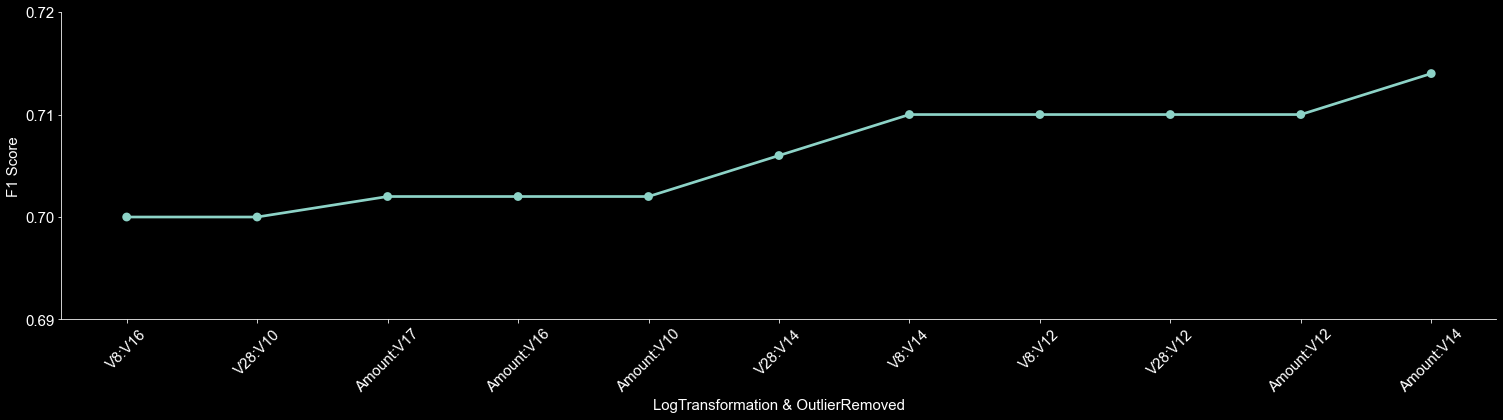

In [9]:
sns.reset_orig()
plt.style.use(['dark_background'])
ax = sns.catplot(x="cat", y="F1", data=results_sorted.iloc[-15:], kind='point',height=5,aspect=25/6)
sns.set(font_scale = 10)
plt.xticks(rotation=45)
ax.set_xticklabels(size=15)
ax.set_yticklabels(size=15)
plt.xlabel("LogTransformation & OutlierRemoved", size=15)
plt.ylabel("F1 Score", size=15)
plt.show()

### PCA

In [10]:
cur_path = os.getcwd()
parent = os.path.abspath(os.path.join(cur_path, os.pardir))
config_file = os.path.join(parent, os.path.join('config', f'{config_file_name}'))
configs = pd.read_excel(config_file, header=None).set_index(0).T
configs = configs.to_dict('list')
ori_file_name = configs['file_name'][0]
configs['file_name'][0] = os.path.join(parent, os.path.join('data', configs['file_name'][0]))
Y_col = configs['y_col'][0]
df_initial = read_data(configs)

df, y_null = y_label_enc(df_initial, configs)
df_organized, discrete, continuous, categorical = organize_data(df, configs, y_null)
pipe = make_imputer_pipe(discrete, continuous, categorical)
df_imputed = do_imputation_whole(df_organized, pipe)
df_scaled = StandardScaler().fit_transform(df_imputed.drop(columns=Y_col))

There are 1 date_time variables
There are 0 discrete variables
There are 29 continuous variables
There are 0 categorical variables


In [11]:
from sklearn.decomposition import PCA
for n_component in range(2,int(len(df_imputed.columns)/2)):
    pca = PCA(n_components=n_component)
    pca.fit(df_scaled)
    df_pca = pca.transform(df_scaled)
    df_pca = pd.DataFrame(df_pca)
    df_pca[Y_col]=df_imputed[Y_col]
    print('PCA n_component', n_component)
    result = pca_train_metric(df_pca, configs, option='logic', logtran='PCA', out_col=n_component)
    results = results.append(result)

PCA n_component 2
logic f1 점수: 0.0 정확도: 1.0 정밀도: 0.0 재현율: 0.0
PCA n_component 3
logic f1 점수: 0.0 정확도: 1.0 정밀도: 0.0 재현율: 0.0
PCA n_component 4
logic f1 점수: 0.44 정확도: 1.0 정밀도: 0.78 재현율: 0.3
PCA n_component 5
logic f1 점수: 0.48 정확도: 1.0 정밀도: 0.88 재현율: 0.33
PCA n_component 6
logic f1 점수: 0.57 정확도: 1.0 정밀도: 0.83 재현율: 0.43
PCA n_component 7
logic f1 점수: 0.46 정확도: 1.0 정밀도: 0.73 재현율: 0.33
PCA n_component 8
logic f1 점수: 0.58 정확도: 1.0 정밀도: 0.84 재현율: 0.45
PCA n_component 9
logic f1 점수: 0.55 정확도: 1.0 정밀도: 0.82 재현율: 0.41
PCA n_component 10
logic f1 점수: 0.62 정확도: 1.0 정밀도: 0.83 재현율: 0.49
PCA n_component 11
logic f1 점수: 0.58 정확도: 1.0 정밀도: 0.84 재현율: 0.45
PCA n_component 12
logic f1 점수: 0.6 정확도: 1.0 정밀도: 0.82 재현율: 0.47
PCA n_component 13
logic f1 점수: 0.65 정확도: 1.0 정밀도: 0.85 재현율: 0.53
PCA n_component 14
logic f1 점수: 0.69 정확도: 1.0 정밀도: 0.87 재현율: 0.57


In [12]:
results_ori2 = results.reset_index(drop=True)
results_ori2['cat'] = results_ori2['LogTrans']+':'+results_ori2['Outliered'].astype(str)
results_sorted = results_ori2.sort_values(['F1','cat'], ascending=[True,False])#.set_index('cat')
results_sorted

,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall,cat
36,logic,PCA,3,0.00,1.00,0.00,0.00,PCA:3
35,logic,PCA,2,0.00,1.00,0.00,0.00,PCA:2
30,LGBM,V8,V17,0.08,0.99,0.05,0.24,V8:V17
34,LGBM,V8,V16,0.08,0.99,0.05,0.24,V8:V16
33,LGBM,V8,V10,0.14,0.99,0.09,0.36,V8:V10
28,LGBM,V28,V10,0.18,0.99,0.12,0.42,V28:V10
20,LGBM,Amount,V17,0.28,1.00,0.24,0.33,Amount:V17
24,LGBM,Amount,V16,0.28,1.00,0.24,0.33,Amount:V16
22,LGBM,Amount,V12,0.29,1.00,0.21,0.44,Amount:V12
32,LGBM,V8,V12,0.30,1.00,0.20,0.55,V8:V12


In [62]:
results_sorted[results_sorted['LogTrans']=='PCA'].sort_values(by=['Outliered','F1'], ascending=[False,True])[results_sorted.columns[3:]]

,F1,Accuracy,Precision,Recall,cat
47,0.69,1.0,0.87,0.57,PCA:14
46,0.65,1.0,0.85,0.53,PCA:13
45,0.60,1.0,0.82,0.47,PCA:12
44,0.58,1.0,0.84,0.45,PCA:11
43,0.62,1.0,0.83,0.49,PCA:10
42,0.55,1.0,0.82,0.41,PCA:9
41,0.58,1.0,0.84,0.45,PCA:8
40,0.46,1.0,0.73,0.33,PCA:7
39,0.57,1.0,0.83,0.43,PCA:6
38,0.48,1.0,0.88,0.33,PCA:5


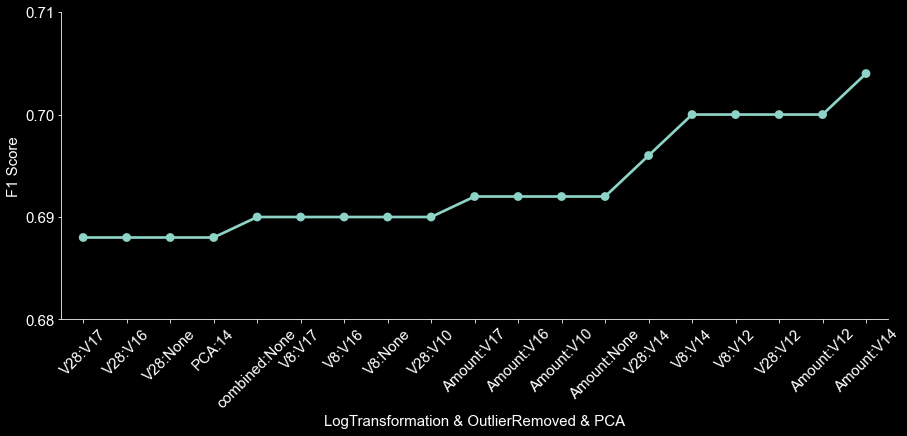

In [56]:
sns.reset_orig()
plt.style.use(['dark_background'])
ax = sns.catplot(x="cat", y="F1", data=results_sorted.iloc[-20:], kind='point',height=5,aspect=15/6)
sns.set(font_scale = 10)
plt.xticks(rotation=45)
ax.set_xticklabels(size=15)
ax.set_yticklabels(size=15)
plt.xlabel("LogTransformation & OutlierRemoved & PCA", size=15)
plt.ylabel("F1 Score", size=15)
plt.show()

### feature importance & permutation importance

#### Feature Importance

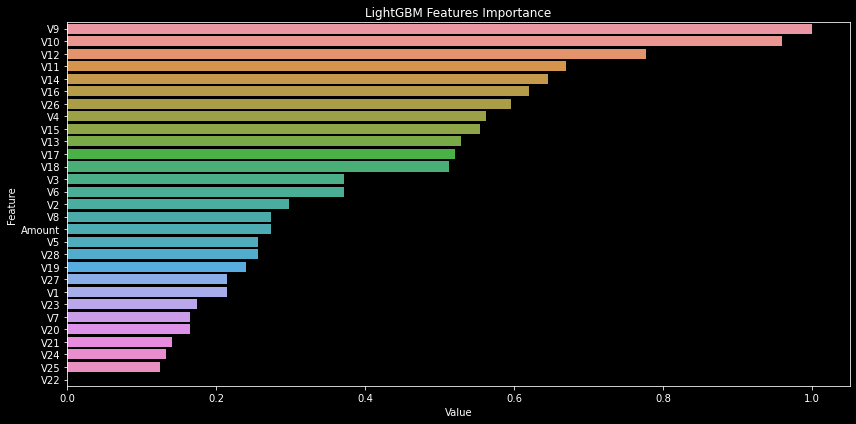

In [14]:
log_col = 'V28'
corr_col = 'V16'
df_processed = log_trans(df_organized, log_col)
df_processed = drop_outlier(df_processed, corr_col, Y_col, yes_value, weight=1.5)
X_train, X_test, y_train, y_test = split_train_test(df_processed, configs)
pipe = make_imputer_pipe(discrete, continuous, categorical)
X_train, X_test, y_train, y_test = do_imputation(X_train, X_test, y_train, y_test, pipe)
model = model_selection('LGBM')
model.fit(X_train, y_train)
scaler = MinMaxScaler()
m_feature_importances = scaler.fit_transform(model.feature_importances_.reshape(-1,1)).reshape(-1)
feature_imp = pd.DataFrame(sorted(zip(m_feature_importances,X_train.columns)), columns=['Value','Feature'])

sns.reset_orig()
plt.style.use(['dark_background'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

#### Permutaion Feature Importance

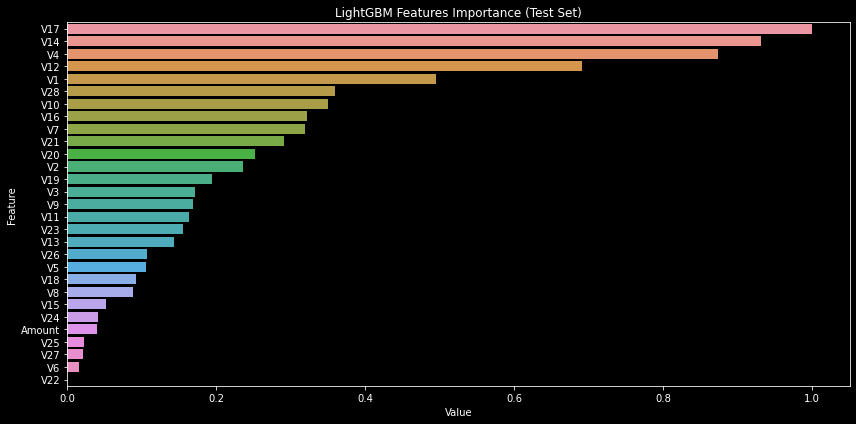

In [15]:
from sklearn.inspection import permutation_importance
sns.reset_orig()
plt.style.use(['dark_background'])

p_feature_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)
scaler = MinMaxScaler()
p_feature_importance = scaler.fit_transform(p_feature_importance.importances_mean.reshape(-1,1)).reshape(-1)

feature_imp = pd.DataFrame(sorted(zip(p_feature_importance,X_test.columns)), columns=['Value','Feature'])
sns.reset_orig()
plt.style.use(['dark_background'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance (Test Set)')
plt.tight_layout()
plt.show()

### Multicollinearity

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
df_temp = df_imputed.drop(columns=Y_col).copy()
vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.shape[1])]
vif["features"] = df_temp.columns
vif_top5 = vif.sort_values(by='VIF Factor',ascending=False).head(5)
vif_top5

,VIF Factor,features
28,5.425575,Amount
1,2.362194,V2
6,1.761454,V7
4,1.720043,V5
19,1.555668,V20


In [44]:
feature_c = pd.DataFrame(continuous, columns=['features'])
feature_c['type'] = 'c'
feature_d = pd.DataFrame(discrete, columns=['features'])
feature_d['type'] = 'd'
feature_ca = pd.DataFrame(categorical, columns=['features'])
feature_ca['type'] = 'ca'
feature_type = pd.concat([feature_c,feature_d,feature_ca]).reset_index(drop=True)
feature_type =vif_top5.merge(feature_type, on='features')
feature_type

,VIF Factor,features,type
0,5.425575,Amount,c
1,2.362194,V2,c
2,1.761454,V7,c
3,1.720043,V5,c
4,1.555668,V20,c


In [49]:
# base score
r0 = split_impute_train(df_organized, configs, discrete, continuous, categorical, option='logistic', logtran='Base Score', out_col=None)

logistic f1 점수: 0.72 정확도: 1.0 정밀도: 0.84 재현율: 0.63


In [50]:
c_list = continuous.copy()
c_list.remove(vif_top5.iloc[0,1])
df_temp = df_organized.drop(columns=vif_top5.iloc[0,1])
r1 = split_impute_train(df_temp, configs, discrete, c_list, categorical, option='logistic', logtran=None, out_col=vif_top5.iloc[0,1])

logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.87 재현율: 0.59


In [51]:
c_list = continuous.copy()
c_list.remove(vif_top5.iloc[1,1])
df_temp = df_organized.drop(columns=vif_top5.iloc[1,1])
r2 = split_impute_train(df_temp, configs, discrete, c_list, categorical, option='logistic', logtran=None, out_col=vif_top5.iloc[1,1])

logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.89 재현율: 0.59


In [52]:
c_list = continuous.copy()
c_list.remove(vif_top5.iloc[2,1])
df_temp = df_organized.drop(columns=vif_top5.iloc[2,1])
r3 = split_impute_train(df_temp, configs, discrete, c_list, categorical, option='logistic', logtran=None, out_col=vif_top5.iloc[2,1])

logistic f1 점수: 0.69 정확도: 1.0 정밀도: 0.88 재현율: 0.57


In [53]:
c_list = continuous.copy()
c_list.remove(vif_top5.iloc[0,1])
c_list.remove(vif_top5.iloc[1,1])
df_temp = df_organized.drop(columns=[vif_top5.iloc[0,1], vif_top5.iloc[1,1]])
cols = vif_top5.iloc[0,1]+'/'+ vif_top5.iloc[1,1]
r4 = split_impute_train(df_temp, configs, discrete, c_list, categorical, option='logistic', logtran=None, out_col=cols)

logistic f1 점수: 0.71 정확도: 1.0 정밀도: 0.87 재현율: 0.6


In [55]:
pd.concat([r0,r1,r2,r3,r4])

,Model,LogTrans,Outliered,F1,Accuracy,Precision,Recall
0,logistic,Base Score,None,0.72,1.0,0.84,0.63
0,logistic,None,Amount,0.71,1.0,0.87,0.59
0,logistic,None,V2,0.71,1.0,0.89,0.59
0,logistic,None,V7,0.69,1.0,0.88,0.57
0,logistic,None,Amount/V2,0.71,1.0,0.87,0.60
